<a href="https://colab.research.google.com/github/OumGhaith/OumGhaith/blob/main/Copie_de_Bienvenue_dans_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchmetrics transformers scikit-learn matplotlib seaborn


  Using cached torchmetrics-1.8.2-py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.2 MB/s eta 0:00:00


In [4]:
# === Step 1: Mount Google Drive (Access dataset stored in Drive) ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# === Step 2: Load & Preprocess Images (Train + Validation) ===
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transform images to 224x224 and normalize
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Load datasets
train_dataset = ImageFolder( '/content/drive/MyDrive/steel_images/train_dataset',

    transform=transform
)
val_dataset = ImageFolder(
    '/content/drive/MyDrive/steel_images/test_dataset',
    transform=transform
)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print("Classes:", train_dataset.classes)


Training images: 1440
Validation images: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [7]:
# === Step 3: Load Pretrained DeiT Small Distilled and Modify Head ===
import torch
from transformers import AutoFeatureExtractor, DeiTForImageClassification

model_name = "facebook/deit-small-distilled-patch16-224"

# Load the feature extractor (preprocess settings for DeiT)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# Load the model with new head for 6 classes
model = DeiTForImageClassification.from_pretrained(
    model_name,
    num_labels=6,
    ignore_mismatched_sizes=True
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and sent to:", device)


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and sent to: cuda


In [8]:
# === Step 5: Train + Evaluate with Accuracy, Precision, Recall, F1, AUC & Confusion Matrix ===
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

# Storage for final evaluation
all_true = []
all_pred = []
all_prob = []

for epoch in range(1, 21):  # adjust epochs as you want
    model.train()
    running_train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    running_val_loss = 0
    true_labels = []
    pred_labels = []
    prob_scores = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            prob_scores.extend(probs.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch} — "
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}"
    )

# --


Epoch 1 — Train Loss: 0.1731 | Val Loss: 0.0141
Epoch 2 — Train Loss: 0.0445 | Val Loss: 0.0056
Epoch 3 — Train Loss: 0.0340 | Val Loss: 0.0153
Epoch 4 — Train Loss: 0.0387 | Val Loss: 0.0205
Epoch 5 — Train Loss: 0.0018 | Val Loss: 0.0032
Epoch 6 — Train Loss: 0.0004 | Val Loss: 0.0240
Epoch 7 — Train Loss: 0.0003 | Val Loss: 0.0232
Epoch 8 — Train Loss: 0.0002 | Val Loss: 0.0018
Epoch 9 — Train Loss: 0.0002 | Val Loss: 0.0240
Epoch 10 — Train Loss: 0.0001 | Val Loss: 0.0041
Epoch 11 — Train Loss: 0.0001 | Val Loss: 0.0020
Epoch 12 — Train Loss: 0.0001 | Val Loss: 0.0269
Epoch 13 — Train Loss: 0.0001 | Val Loss: 0.0274
Epoch 14 — Train Loss: 0.0001 | Val Loss: 0.0044
Epoch 15 — Train Loss: 0.0001 | Val Loss: 0.0020
Epoch 16 — Train Loss: 0.0001 | Val Loss: 0.0256
Epoch 17 — Train Loss: 0.0001 | Val Loss: 0.0020
Epoch 18 — Train Loss: 0.0000 | Val Loss: 0.0285
Epoch 19 — Train Loss: 0.0000 | Val Loss: 0.0021
Epoch 20 — Train Loss: 0.0000 | Val Loss: 0.0263


In [10]:
# === Step 6: Compute Evaluation Metrics on Validation Set ===
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Switch model to eval mode
model.eval()

all_true = []
all_pred = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits

        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to arrays
all_true = np.array(all_true)
all_pred = np.array(all_pred)
all_probs = np.array(all_probs)

# Accuracy
acc = accuracy_score(all_true, all_pred) * 100

# Precision, Recall, F1 (macro‑average)
precision_macro = precision_score(all_true, all_pred, average='macro') * 100
recall_macro    = recall_score(all_true, all_pred, average='macro') * 100
f1_macro        = f1_score(all_true, all_pred, average='macro') * 100

# Confusion Matrix
cm = confusion_matrix(all_true, all_pred)

# Classification Report (per class)
report = classification_report(all_true, all_pred, digits=4)

# Multiclass ROC‑AUC
try:
    ohe_true = np.eye(len(cm))[all_true]  # one‑hot encode true labels
    auc_score = roc_auc_score(ohe_true, all_probs, multi_class='ovr') * 100
except Exception as e:
    auc_score = None
    print("AUC could not be computed:", e)

# Print results
print("=== Validation Evaluation Metrics ===")
print(f"Accuracy (%):             {acc:.2f}")
print(f"Precision (macro, %):     {precision_macro:.2f}")
print(f"Recall (macro, %):        {recall_macro:.2f}")
print(f"F1‑Score (macro, %):      {f1_macro:.2f}")
print(f"ROC‑AUC (multiclass, %):  {auc_score if auc_score is not None else 'N/A'}\n")

print("Classification Report (per class):")
print(report)

print("Confusion Matrix:")
print(cm)


=== Validation Evaluation Metrics ===
Accuracy (%):             99.44
Precision (macro, %):     99.45
Recall (macro, %):        99.44
F1‑Score (macro, %):      99.44
ROC‑AUC (multiclass, %):  99.99444444444445

Classification Report (per class):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     1.0000    0.9667    0.9831        60
           2     1.0000    1.0000    1.0000        60
           3     0.9836    1.0000    0.9917        60
           4     1.0000    1.0000    1.0000        60
           5     0.9836    1.0000    0.9917        60

    accuracy                         0.9944       360
   macro avg     0.9945    0.9944    0.9944       360
weighted avg     0.9945    0.9944    0.9944       360

Confusion Matrix:
[[60  0  0  0  0  0]
 [ 0 58  0  1  0  1]
 [ 0  0 60  0  0  0]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]


In [11]:
# === Step 7: Save Model Weights to Google Drive ===

save_path = "/content/drive/MyDrive/steel_images/my_deit_model.pt"

torch.save(model.state_dict(), save_path)

print("✅ Model weights saved to:", save_path)


✅ Model weights saved to: /content/drive/MyDrive/steel_images/my_deit_model.pt


In [5]:
from google.colab import files

files.download("/content/drive/MyDrive/steel_images/my_deit_model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


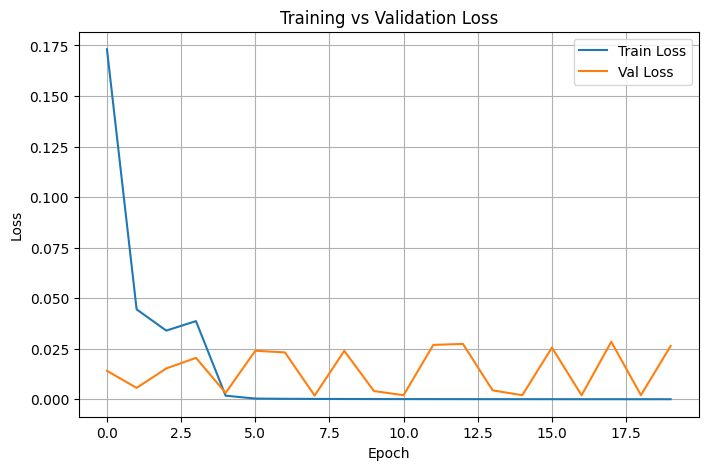

In [14]:
# === Step 7: Plot Train vs Val Loss ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


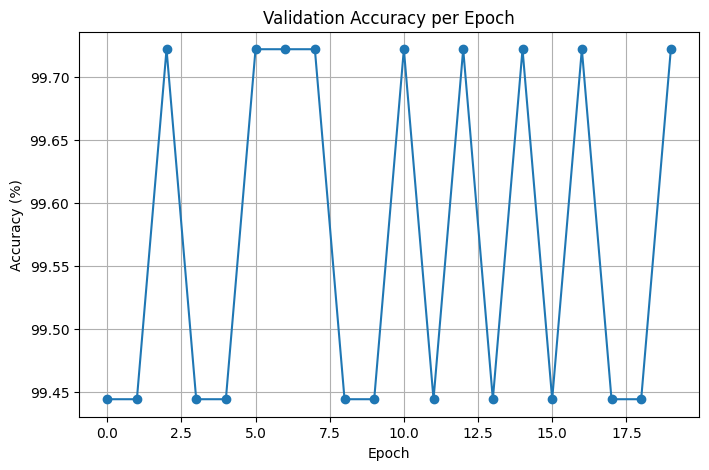

In [15]:
# === Plot Validation Accuracy per Epoch ===
val_accuracies = []

model.eval()
with torch.no_grad():
    for i in range(len(val_losses)):  # reuse number of epochs
        correct = 0
        total   = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds   = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
        val_accuracies.append(100 * correct / total)

plt.figure(figsize=(8,5))
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


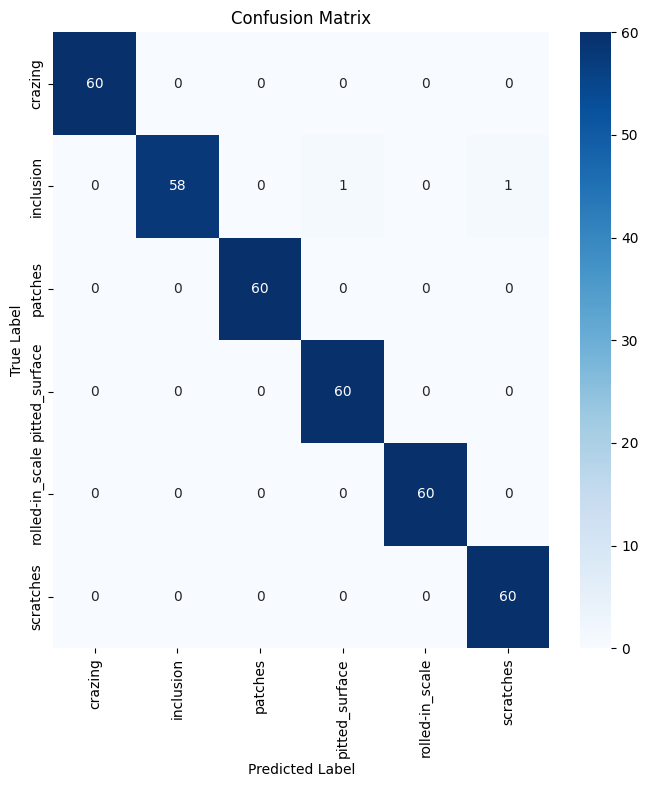

In [16]:
# === Step 8: Confusion Matrix Heatmap ===
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


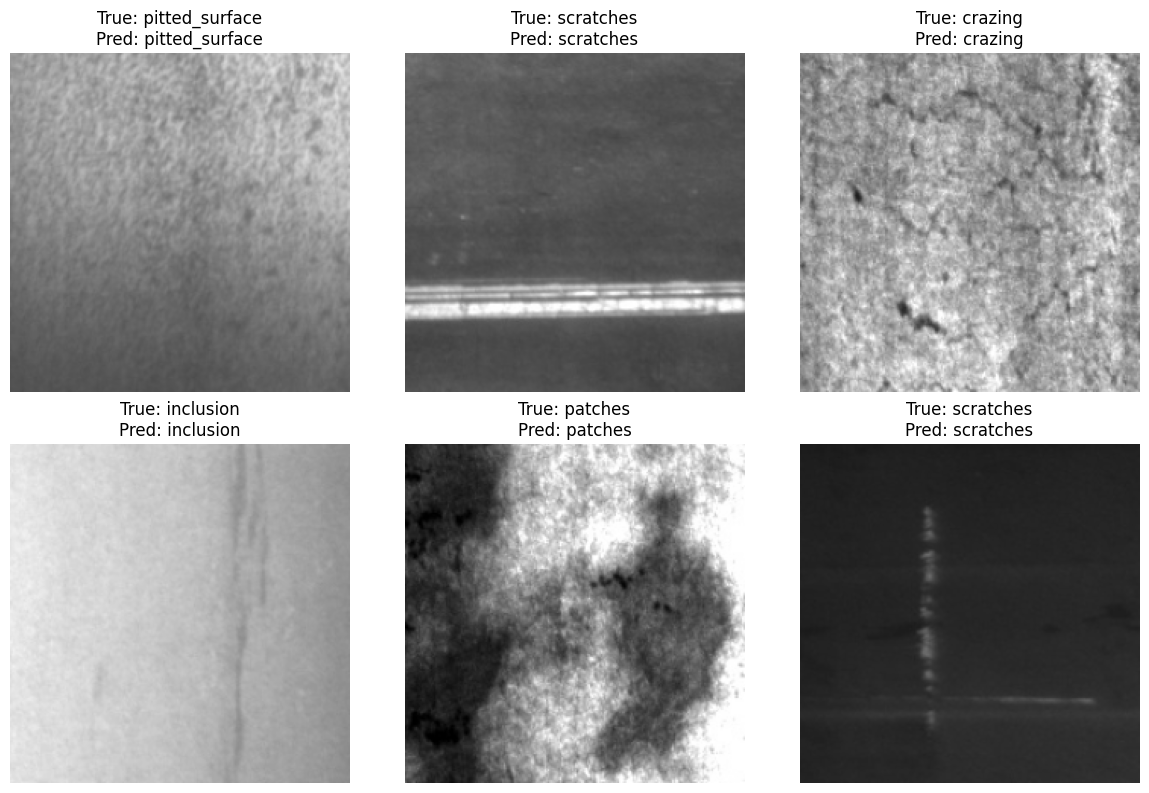

In [17]:
# === Step 9: Show Some Sample Predictions ===
import random
import matplotlib.pyplot as plt

model.eval()

fig = plt.figure(figsize=(12,8))
for i in range(6):  # show 6 random samples
    idx = random.randint(0, len(val_dataset)-1)
    img, true_label = val_dataset[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device)).logits
        pred_label = torch.argmax(output, dim=1).item()

    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy() * 0.5 + 0.5)  # unnormalize
    ax.set_title(f"True: {train_dataset.classes[true_label]}\nPred: {train_dataset.classes[pred_label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

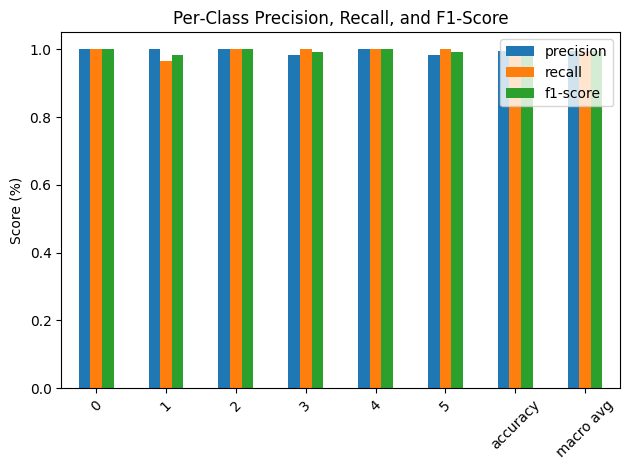

✅ Per‑class metrics bar chart saved!


In [18]:
# === Plot Per-Class Precision, Recall, and F1 Bars ===
import pandas as pd
import matplotlib.pyplot as plt

# Build data frame from classification_report
from sklearn.metrics import classification_report

report_dict = classification_report(all_true, all_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().iloc[:-1, :3]  # drop accuracy row

# Plot it
plt.figure(figsize=(10, 6))
df_report[['precision','recall','f1-score']].plot(kind='bar')
plt.title("Per‑Class Precision, Recall, and F1‑Score")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()

# Save to file
plt.savefig("/content/drive/MyDrive/steel_images/per_class_metrics_bar.png")
plt.show()

print("✅ Per‑class metrics bar chart saved!")


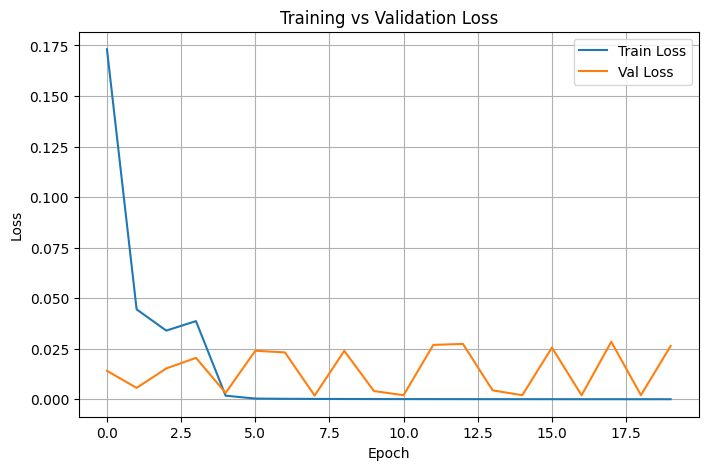

✅ Loss curves saved!


In [19]:
# === Save Train vs Val Loss Plot ===
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/steel_images/loss_curves.png")
plt.show()

print("✅ Loss curves saved!")


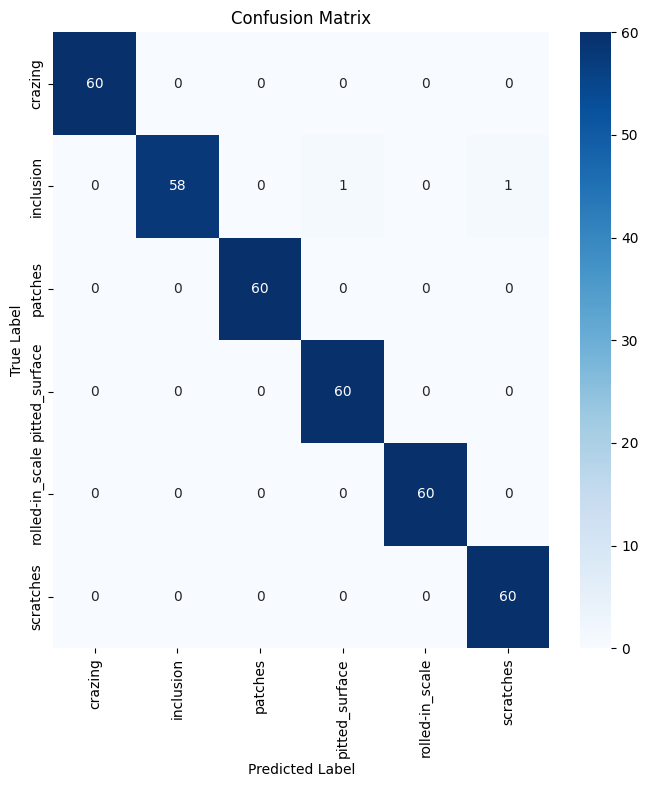

✅ Confusion matrix saved!


In [20]:
# === Save Confusion Matrix Heatmap ===
import seaborn as sns

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("/content/drive/MyDrive/steel_images/confusion_matrix.png")
plt.show()

print("✅ Confusion matrix saved!")


In [21]:
# === Step: Generate Simple HTML Report ===

html = f"""
<html>
<head><title>Steel Defect Classification Report</title></head>
<body>
<h1>Model Performance Report</h1>

<h2>Overall Metrics</h2>
<p><b>Accuracy:</b> {acc:.2f}%</p>
<p><b>Precision (macro):</b> {precision_macro:.2f}%</p>
<p><b>Recall (macro):</b> {recall_macro:.2f}%</p>
<p><b>F1‑Score (macro):</b> {f1_macro:.2f}%</p>
<p><b>ROC‑AUC (multiclass):</b> {auc_score if auc_score else 'N/A'}%</p>

<h2>Confusion Matrix</h2>
<img src="confusion_matrix.png" width="50%" />

<h2>Loss Curves</h2>
<img src="loss_curves.png" width="50%" />

<h2>Per‑Class Metrics</h2>
<img src="per_class_metrics_bar.png" width="60%" />

<h2>Detailed Classification Report</h2>
<pre>{classification_report(all_true, all_pred, digits=4)}</pre>

</body>
</html>
"""

with open("/content/drive/MyDrive/steel_images/report.html", "w") as f:
    f.write(html)

print("📄 Report saved to Drive!")


📄 Report saved to Drive!


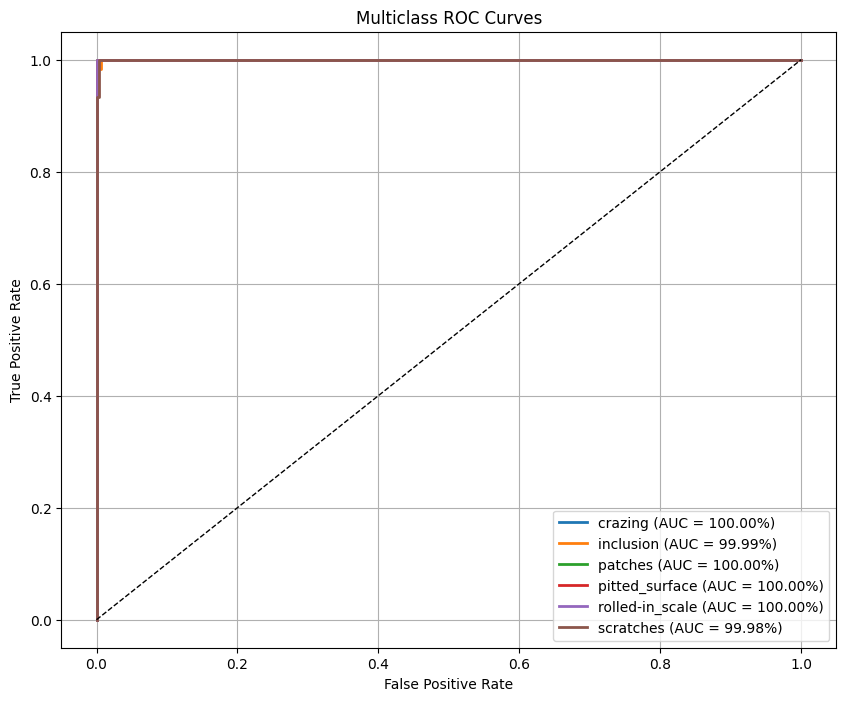

✅ Saved ROC plot to: /content/drive/MyDrive/steel_images/multiclass_roc.png


In [23]:
# === Plot ROC Curves for Each Class (Multiclass) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One‑hot encode true labels
y_true_ohe = label_binarize(all_true, classes=np.arange(len(train_dataset.classes)))
n_classes = y_true_ohe.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"{train_dataset.classes[i]} (AUC = {roc_auc[i]*100:.2f}%)")

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title("Multiclass ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)

save_path_roc = "/content/drive/MyDrive/steel_images/multiclass_roc.png"
plt.savefig(save_path_roc)
plt.show()
print("✅ Saved ROC plot to:", save_path_roc)


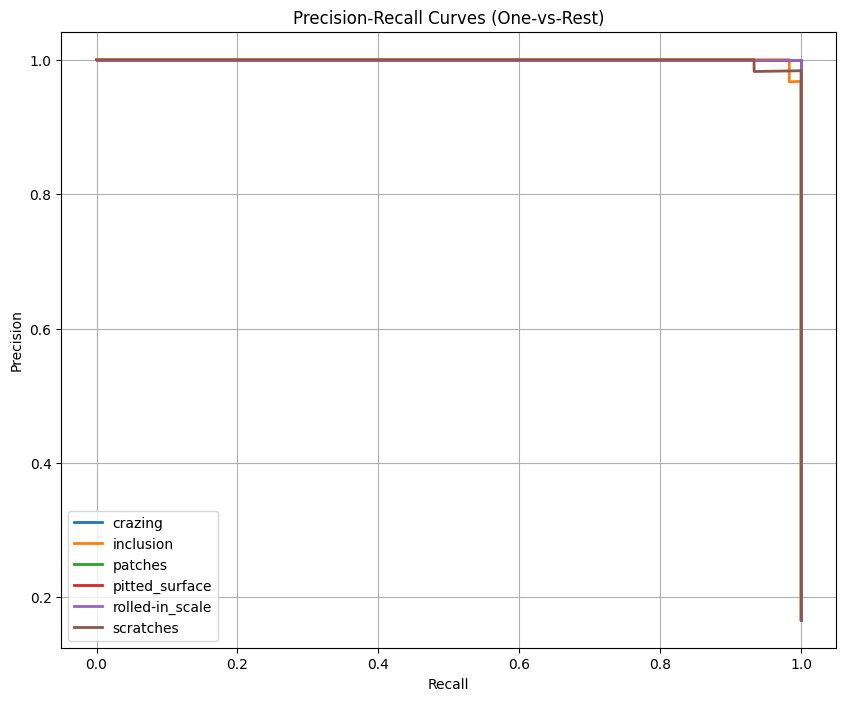

✅ Saved Precision‑Recall plot to: /content/drive/MyDrive/steel_images/multiclass_pr_curve.png


In [24]:
# === Plot Precision‑Recall Curves for Each Class ===
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10,8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_ohe[:, i], all_probs[:, i])
    plt.plot(recall, precision, lw=2,
             label=f"{train_dataset.classes[i]}")

plt.title("Precision‑Recall Curves (One‑vs‑Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)

save_path_pr = "/content/drive/MyDrive/steel_images/multiclass_pr_curve.png"
plt.savefig(save_path_pr)
plt.show()
print("✅ Saved Precision‑Recall plot to:", save_path_pr)


In [7]:
from transformers import DeiTForImageClassification

# 1️⃣ Re-create the model architecture
model_name = "facebook/deit-small-distilled-patch16-224"
model = DeiTForImageClassification.from_pretrained(
    model_name,
    num_labels=6,
    ignore_mismatched_sizes=True
)

# 2️⃣ Load the saved weights
model.load_state_dict(torch.load(save_path))
model.eval()

# 3️⃣ Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
          

In [8]:
import torch
from transformers import DeiTForImageClassification
import time
import os

# === 1️⃣ Load Model Architecture & Trained Weights ===
model_name = "facebook/deit-small-distilled-patch16-224"
num_classes = 6
save_path = "/content/drive/MyDrive/steel_images/my_deit_model.pt"

# Recreate model (pretrained backbone)
model = DeiTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# Load your trained weights
model.load_state_dict(torch.load(save_path))
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === 2️⃣ Count Parameters ===
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# === 3️⃣ Model Size on Disk ===
model_file_size = os.path.getsize(save_path) / (1024 * 1024)  # in MB
print(f"Model Size on Disk: {model_file_size:.2f} MB")

# === 4️⃣ Measure Inference Time per Image ===
# Use a dummy input (224x224 RGB)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up (GPU first pass is slower)
with torch.no_grad():
    for _ in range(5):
        _ = model(dummy_input)

# Time it
num_runs = 50
start_time = time.time()
with torch.no_grad():
    for _ in range(num_runs):
        _ = model(dummy_input)
end_time = time.time()

avg_inference_time_ms = (end_time - start_time) / num_runs * 1000
print(f"Average Inference Time per Image: {avg_inference_time_ms:.2f} ms")


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 21,668,742
Trainable Parameters: 21,668,742
Model Size on Disk: 82.74 MB
Average Inference Time per Image: 14.77 ms


In [9]:
import torch
import numpy as np
from transformers import DeiTForImageClassification
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
)
import time
import os

# === 1️⃣ Load Model & Trained Weights ===
model_name = "facebook/deit-small-distilled-patch16-224"
num_classes = 6
save_path = "/content/drive/MyDrive/steel_images/my_deit_model.pt"

model = DeiTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(save_path))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === 2️⃣ Load Validation Data ===
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

val_dataset = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# === 3️⃣ Evaluate on Validation Set ===
all_true = []
all_pred = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_true = np.array(all_true)
all_pred = np.array(all_pred)
all_probs = np.array(all_probs)

# --- Accuracy & Macro Metrics ---
accuracy = accuracy_score(all_true, all_pred) * 100
precision_macro = precision_score(all_true, all_pred, average='macro') * 100
recall_macro = recall_score(all_true, all_pred, average='macro') * 100
f1_macro = f1_score(all_true, all_pred, average='macro') * 100

# --- Per-Class F1 ---
report_dict = classification_report(all_true, all_pred, output_dict=True)
per_class_f1 = {cls: round(metrics['f1-score']*100, 2) for cls, metrics in report_dict.items() if cls not in ['accuracy','macro avg','weighted avg']}

# --- Confusion Matrix ---
cm = confusion_matrix(all_true, all_pred)

# --- Multiclass ROC-AUC ---
try:
    ohe_true = np.eye(num_classes)[all_true]
    roc_auc_macro = roc_auc_score(ohe_true, all_probs, multi_class='ovr') * 100
except:
    roc_auc_macro = None

# === 4️⃣ Efficiency Metrics ===

# Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model size
model_file_size = os.path.getsize(save_path) / (1024*1024)

# Inference time per image (dummy input)
dummy_input = torch.randn(1,3,224,224).to(device)
with torch.no_grad():
    for _ in range(5):  # warm-up
        _ = model(dummy_input)

num_runs = 50
start_time = time.time()
with torch.no_grad():
    for _ in range(num_runs):
        _ = model(dummy_input)
end_time = time.time()

avg_inference_ms = (end_time - start_time) / num_runs * 1000

# === 5️⃣ Print Summary ===
print("=== Model Performance & Efficiency Summary ===")
print(f"Accuracy (%): {accuracy:.2f}")
print(f"Macro Precision (%): {precision_macro:.2f}")
print(f"Macro Recall (%): {recall_macro:.2f}")
print(f"Macro F1 (%): {f1_macro:.2f}")
print(f"Per-Class F1 (%): {per_class_f1}")
print(f"ROC-AUC (macro, %): {roc_auc_macro if roc_auc_macro else 'N/A'}")
print(f"Confusion Matrix:\n{cm}\n")
print("=== Efficiency Metrics ===")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size on Disk: {model_file_size:.2f} MB")
print(f"Average Inference Time per Image: {avg_inference_ms:.2f} ms")


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Model Performance & Efficiency Summary ===
Accuracy (%): 99.72
Macro Precision (%): 99.73
Macro Recall (%): 99.72
Macro F1 (%): 99.72
Per-Class F1 (%): {'0': 100.0, '1': 99.16, '2': 100.0, '3': 99.17, '4': 100.0, '5': 100.0}
ROC-AUC (macro, %): 100.0
Confusion Matrix:
[[60  0  0  0  0  0]
 [ 0 59  0  1  0  0]
 [ 0  0 60  0  0  0]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]

=== Efficiency Metrics ===
Total Parameters: 21,668,742
Trainable Parameters: 21,668,742
Model Size on Disk: 82.74 MB
Average Inference Time per Image: 7.66 ms
